In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
from tensorflow.keras.datasets.mnist import load_data

(x_train, y_train), (x_test, y_test) = load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

2024-05-02 09:40:10.389703: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 09:40:10.389800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 09:40:10.570764: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


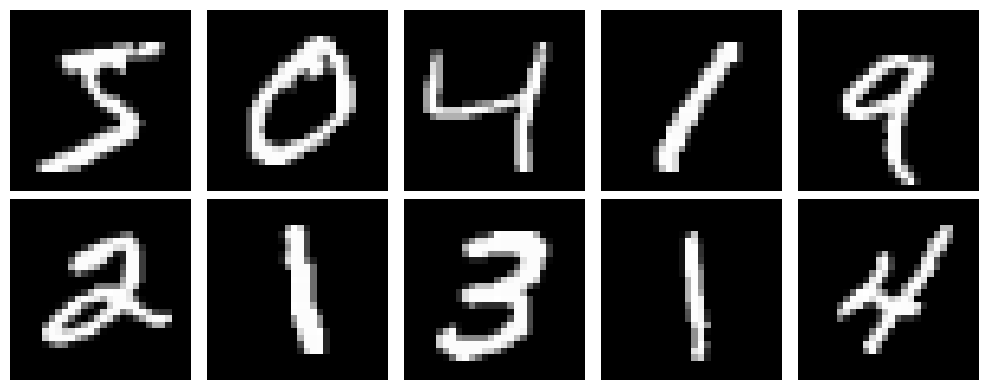

In [2]:
def plot_samples(data):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i], cmap = "gray")
        ax.axis("off")
    fig.tight_layout()

plot_samples(x_train)

In [3]:

# plot_samples(x_train[50000])
x_train[50000].shape

(28, 28)

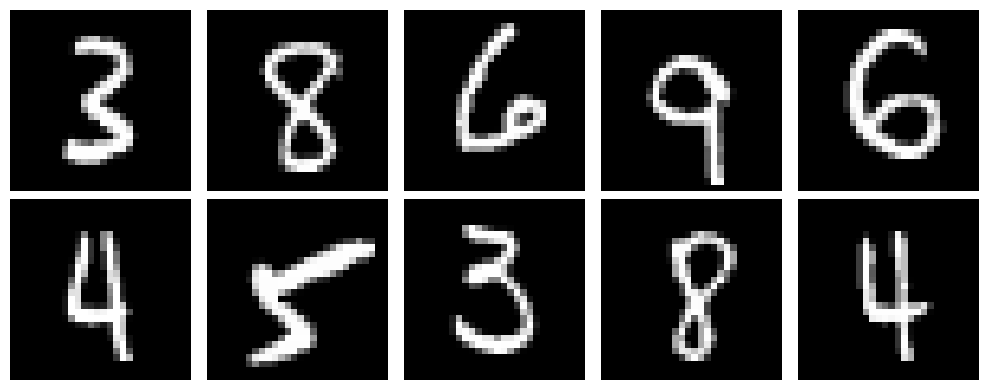

In [5]:
plot_samples(x_train[50000:50010])

In [6]:
X_train = x_train.astype("float32")/255
X_test = x_test.astype("float32")/255
X_train.min(), X_train.max()

(0.0, 1.0)

## Train|val|test split

In [7]:
from sklearn.model_selection import train_test_split

# we already have X_train: 60000 samples 
# X_train_val: 50000 samples -> training part for validation and hyperparameter tuning
# X_val: 10000 samples -> validation used for hyperparameter tuning and validation loss curves
# train on train_val and validate on val to hyperparameter tune, then when finished train on whole training data set
X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=1 / 6, random_state=42
)

# rank 3 
X_train_val.shape, X_val.shape

((50000, 28, 28), (10000, 28, 28))

In [8]:
# we will use ImageDataGenerator to augment our data
# it requires rank 4 e.g. (50000,28,28,3), (10000,28,28,1)
X_train_val[..., None].shape


(50000, 28, 28, 1)

In [9]:
X_train_val = X_train_val[..., None]
X_train = X_train[..., None]
X_val = X_val[..., None]
X_test = X_test[..., None]

X_train_val.shape


(50000, 28, 28, 1)

## Data augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

help(ImageDataGenerator())

Help on ImageDataGenerator in module keras.src.legacy.preprocessing.image object:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |  
 |  DEPRECATED.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom

In [11]:
train_image_generator = ImageDataGenerator(rotation_range=90)

# batch size 32 - used for mini-batch gradient descent - which gives us stochasticity in backpropagation
# flow is used for regenerating images after it has been exhausted 
# this is because we will train in many epochs 
train_generator = train_image_generator.flow(X_train, y_train, batch_size=32) 

train_generator

In [12]:
# 32 gray scaled images - this is first batch
train_generator[0][0].shape

(32, 28, 28, 1)

In [13]:
train_generator[1][0].shape # 2nd batch

(32, 28, 28, 1)

In [14]:
train_generator[1][1].shape # labels for 2nd batch

(32,)

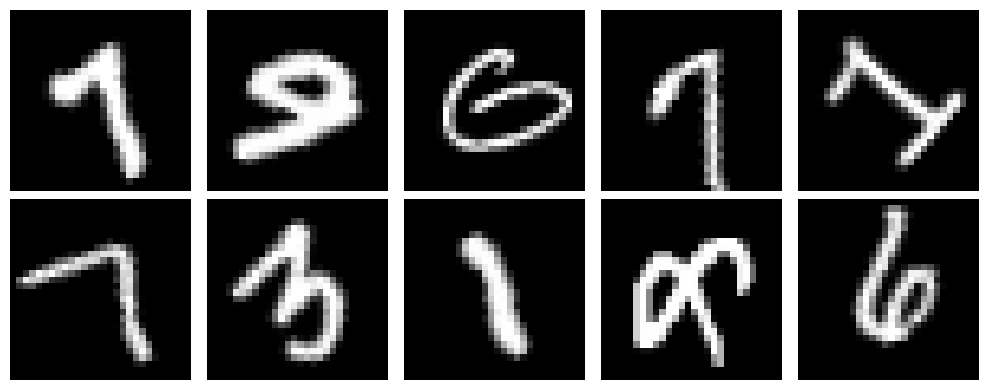

In [15]:
# illustrates what happens with up to 90° rotation
plot_samples(next(train_generator)[0])

## Make a good augmenatation

In [16]:
train_image_generator = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    height_shift_range=0.1,
    width_shift_range=0.2,
)

# don't augment test data and validation data - want to test on original data
# this is used for mini-batch in training
test_image_generator = ImageDataGenerator()

train_generator = train_image_generator.flow(X_train, y_train, batch_size=32)
train_val_generator = train_image_generator.flow(X_train_val, y_train_val, batch_size=32)
val_generator = test_image_generator.flow(X_val, y_val, batch_size=32)

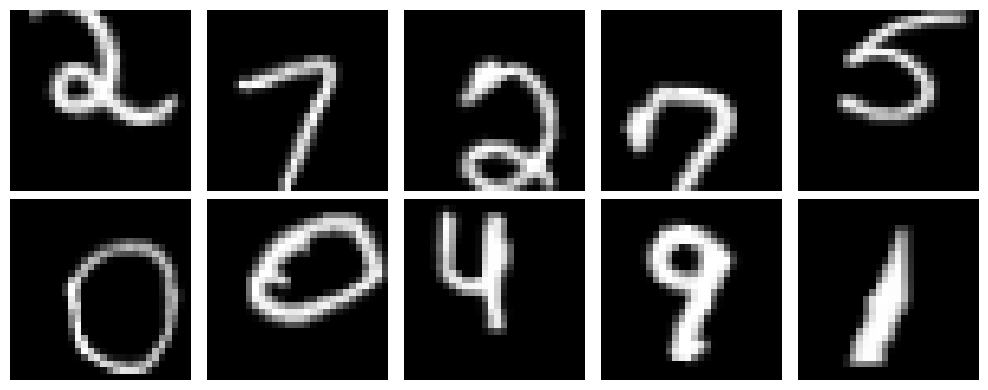

In [17]:
plot_samples(next(train_generator)[0])

## CNN model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def cnn_model(learning_rate=0.001, drop_rate=0.5, kernels=[32, 32]):
    adam = Adam(learning_rate=learning_rate)

    model = Sequential(name="CNN_model")

    for number_kernel in kernels:
        conv_layer = Conv2D(
            number_kernel,
            kernel_size=(3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=X_train.shape[1:],
        )

        model.add(conv_layer)
        # defaults to pool_size if None
        model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

    # MLP part
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(10, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["acc"]
    )

    return model

model = cnn_model(drop_rate=.5)

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,194 (848.41 KB)

 Trainable params: 217,194 (848.41 KB)

 Non-trainable params: 0 (0.00 B)

## Train on augmented data

In [19]:
# number of steps for minibatch in one epoch 
steps_per_epoch = len(X_train_val)//32
validation_steps = len(X_val)//32

# number of batches to be ran in one epoch
steps_per_epoch, validation_steps

(1562, 312)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(
    monitor="val_acc", mode="max", patience=5, restore_best_weights=True
)

model.fit(
    train_val_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    callbacks=[early_stopper],
    validation_data = val_generator, # this will give us batches for validation
    validation_steps = validation_steps
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  16/1562 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - acc: 0.1404 - loss: 2.9595

I0000 00:00:1714643030.693993     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714643030.711661     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1554/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.7060 - loss: 0.8907

W0000 00:00:1714643052.222889     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - acc: 0.7067 - loss: 0.8885 - val_acc: 0.9736 - val_loss: 0.0946
Epoch 2/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 1.0000 - loss: 0.0946

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - acc: 1.0000 - loss: 0.0946 - val_acc: 0.9375 - val_loss: 0.0868
Epoch 3/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - acc: 0.9277 - loss: 0.2296 - val_acc: 0.9754 - val_loss: 0.0771
Epoch 4/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - acc: 0.9688 - loss: 0.1575 - val_acc: 0.9375 - val_loss: 0.1096
Epoch 5/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - acc: 0.9441 - loss: 0.1734 - val_acc: 0.9849 - val_loss: 0.0517
Epoch 6/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 11us/step - acc: 0.8438 - loss: 0.3139 - val_acc: 1.0000 - val_loss: 0.0028
Epoch 7/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - acc: 0.9537 - loss: 0.1439 - val_acc: 0.9863 - val_loss: 0.0426
Epoch 8/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 9us/step - acc: 0.9062 - loss: 0.2491 - val_acc: 1.0000 - val_loss: 0.0182
Epoch 9/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - acc: 0.9583 - loss: 0.1353 - val_acc: 0.9873 - val_loss: 0.0392
Epoch 10/50
1562/1562 ━━━━━━━━━━━━━━━━━━

In [23]:
metrics = pd.DataFrame(model.history.history)
metrics

,acc,loss,val_acc,val_loss
0,0.835375,0.507797,0.973558,0.094643
1,1.000000,0.094634,0.937500,0.086760
2,0.932877,0.212862,0.975361,0.077108
3,0.968750,0.157456,0.937500,0.109605
4,0.946646,0.166141,0.984876,0.051727
5,0.843750,0.313856,1.000000,0.002798
6,0.955131,0.141498,0.986278,0.042618
7,0.906250,0.249146,1.000000,0.018162
8,0.958874,0.131792,0.987280,0.039186
9,1.000000,0.030802,0.937500,0.075158


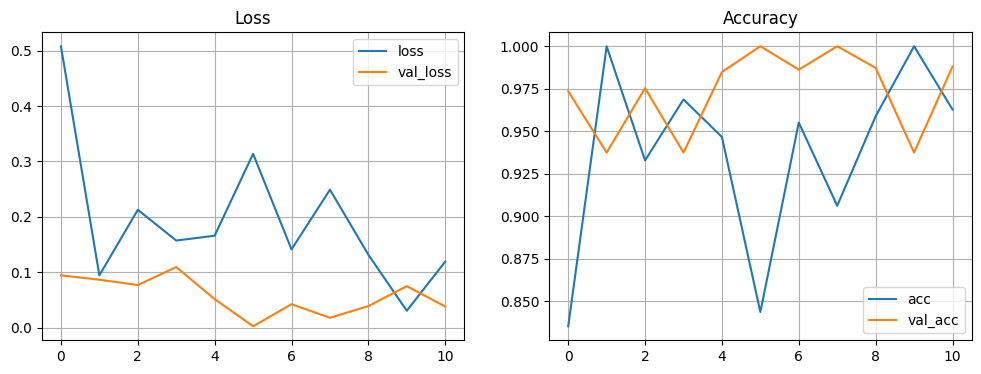

In [24]:

def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True)

# harder to overfit
plot_metrics(metrics)

In [25]:
model = cnn_model()
# can recalculate steps_per_epoch to be 60000/32 instead of 50000/32
model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=10)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  16/1562 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - acc: 0.1214 - loss: 2.5564

W0000 00:00:1714643449.709620     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - acc: 0.7082 - loss: 0.8765
Epoch 2/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9225 - loss: 0.2408  
Epoch 3/10
   6/1562 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - acc: 0.9728 - loss: 0.0985 

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - acc: 0.9345 - loss: 0.2127
Epoch 4/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9409 - loss: 0.1789  
Epoch 5/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - acc: 0.9498 - loss: 0.1659
Epoch 6/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9542 - loss: 0.1503  
Epoch 7/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - acc: 0.9557 - loss: 0.1414
Epoch 8/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.9593 - loss: 0.1317  
Epoch 9/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - acc: 0.9581 - loss: 0.1316
Epoch 10/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9648 - loss: 0.1115  


In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred

122/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1714643655.902803     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[2.89935662e-11, 7.63760852e-07, 6.62552120e-05, ...,
        9.99932647e-01, 2.12822489e-08, 1.10812188e-07],
       [2.61663172e-06, 1.75487912e-05, 9.99975920e-01, ...,
        3.49672496e-06, 6.10639219e-08, 1.88333420e-08],
       [1.69401986e-08, 9.99997258e-01, 2.13760054e-09, ...,
        2.20446893e-07, 1.15187895e-08, 6.00794152e-08],
       ...,
       [1.20457658e-10, 1.40003897e-09, 1.26281638e-10, ...,
        4.26882973e-09, 2.55063100e-08, 6.68251346e-07],
       [5.36692880e-07, 1.51751334e-09, 9.48282253e-09, ...,
        7.58327001e-09, 2.49156346e-05, 1.91642812e-05],
       [2.82143503e-07, 1.10320190e-11, 3.82272036e-09, ...,
        5.89786304e-13, 6.10526001e-07, 3.84358589e-09]], dtype=float32)

In [28]:
y_pred[0], y_test[0]

(array([2.8993566e-11, 7.6376085e-07, 6.6255212e-05, 1.9402570e-07,
        2.6379352e-08, 5.0696388e-11, 2.7801855e-11, 9.9993265e-01,
        2.1282249e-08, 1.1081219e-07], dtype=float32),
 7)

In [29]:
y_pred[50], y_test[50]

(array([7.1404971e-09, 6.5514316e-11, 2.5424207e-10, 1.1821594e-10,
        4.3086836e-09, 6.5540730e-06, 9.9999332e-01, 4.2271941e-12,
        1.2327222e-07, 2.7905418e-09], dtype=float32),
 6)

In [31]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([7, 2, 1, ..., 4, 5, 6])

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.98      1.00      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



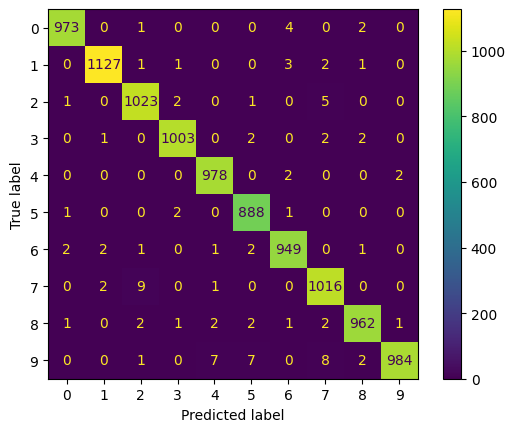

In [34]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()